In [41]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import yaml
with open('../system_config.yml','r') as stream:
    sysconfig = yaml.safe_load(stream)

import utils.simulation2d as project
data_dir = Path(sysconfig['data_dir'],'re400/')
dt = 0.0002*625

{'data_dir': './local_data/'}


In [27]:
(ux,uy,pp) = project.read_data(data_dir,idx_body=132)
# take base measurement
pb = project.take_measurement_base(pp, ly=[1.5,2.5] ,centrex=0, domain_y=4)

In [28]:
probe_location = (300,50)
probe_ux = ux[:,probe_location[0],probe_location[1]]
probe_uy = uy[:,probe_location[0],probe_location[1]]
probe_p = pb[:,probe_location[1]-49]

freq = np.fft.fftfreq(len(probe_ux),d=dt)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)

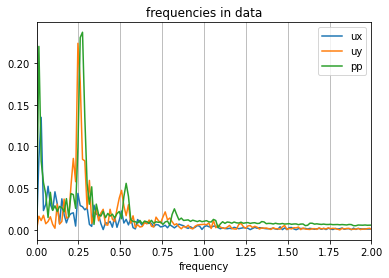

highest peak at  0.2607204116638079  Hz.


In [29]:
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()
idx_sort = np.argsort(f_uy)
high_freq = freq[idx_sort][-1]
print("highest peak at ", high_freq, " Hz.")

In [30]:
amp = np.abs(f_uy[idx_sort][-1])
phase = np.angle(f_uy[idx_sort][-1])

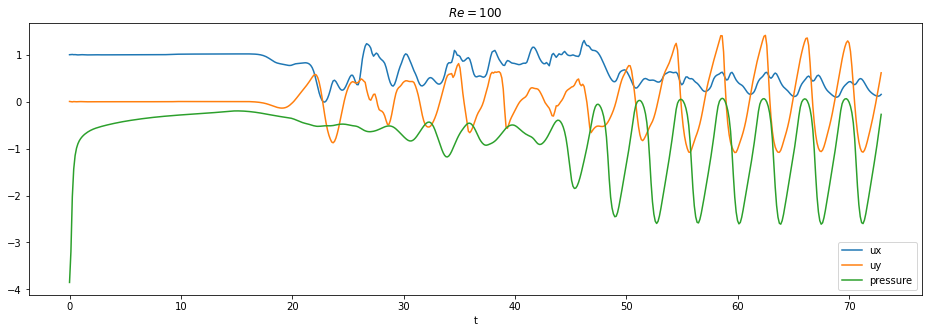

In [31]:
t = np.linspace(0,probe_ux.shape[0]*dt,probe_ux.shape[0])
plt.figure(figsize=(16,5))
plt.title("$Re=100$")
plt.plot(t,probe_ux,label='ux')
plt.plot(t,probe_uy,label='uy')
plt.plot(t,probe_p,label='pressure')
# plt.plot(t,2*amp*np.cos(high_freq*2*np.pi*t+phase),label='main fft freq')
plt.legend()
# plt.xlim([0,20])
plt.xlabel("t")
plt.show()

# Vorticity

In [32]:
import h5py 
with h5py.File(data_dir+'vort.h5','r') as hf:
    vort = np.array(hf.get('vort'))
with h5py.File(data_dir+'critq.h5','r') as hf:
    critq = np.array(hf.get('critq'))
vort.shape

(583, 513, 129)

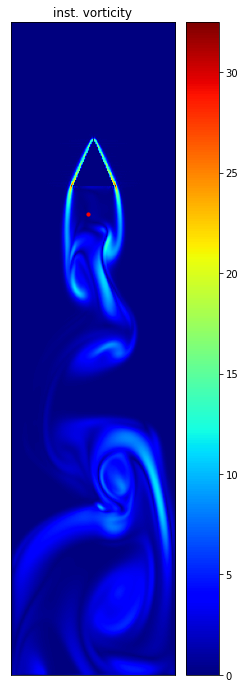

In [33]:
plt.figure(figsize=(4,12))
plt.title('inst. vorticity')
plt.imshow(vort[200,...],'jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.scatter(60,150,s=10,c='r')
plt.show()

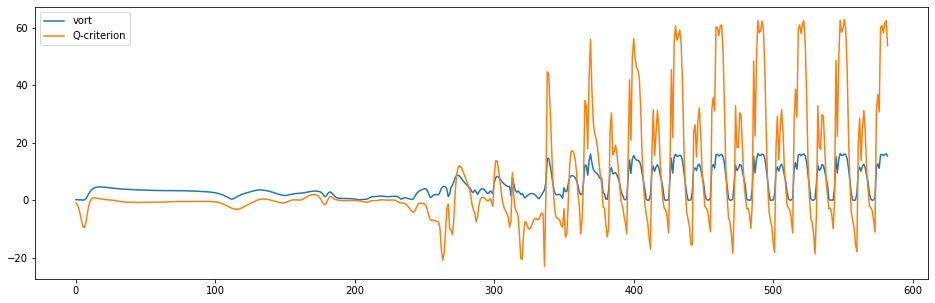

In [34]:
probe_vort = vort[:,150,60]
probe_q = critq[:,150,60]
plt.figure(figsize=(16,5))
plt.plot(probe_vort,label='vort')
plt.plot(probe_q,label='Q-criterion')
plt.legend()
plt.show()


# Make gif

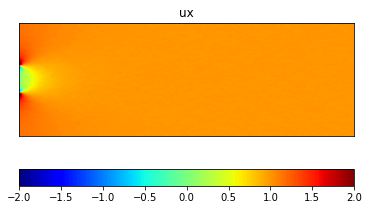

In [38]:
from matplotlib import animation

fps = 24
sec = 24
plt_data = np.einsum('t x y -> t y x',ux)
fig_gif = plt.figure()
im = plt.imshow(plt_data[0,:,:],vmin =-2, vmax=2, cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title('ux')
plt.xticks([])
plt.yticks([])
plt.show()

def animation_fun(i):
    im.set_array(plt.data[i,:,:])
    return[im]

gif = animation.FuncAnimation(fig_gif,
                                animation_fun,
                                frames=np.arange(fps*sec),
                                interval=1000/fps,
                                repeat=False)
gif.save('data_animation.gif',fps=fps)